<h1 align="center">
<font color='magenta'>
DRAFTS FOR ROUTINES IN THE CODE
</font>
</h1> 

<h3 align="center">
<font color='magenta'>
plot:  http://moderndata.plot.ly/graph-data-from-mysql-database-in-python/
<br>
http://nbviewer.ipython.org/gist/jackparmer/5485807511a58be48bf2
<br><br>
mysql: http://zetcode.com/db/mysqlpython/

</font>
</h3> 

In [35]:
import MySQLdb as mdb
import sys
#import nltk
import pandas as pd
from textstat.textstat import textstat
import copy
import numpy as np

In [17]:
# import plotly

#  --- IMPLEMENTED: ------------
read_in_mysql()

find_difficulty(df)

find_related_asins(asin, dfm, depth):

find_related_asins_depth1(asin, dfm):

make_relevant_meta_df(asin,dfm,max_depth):
    


In [190]:
# good asins

df_m[df_m.title == 'Classical Mechanics']

,asin,title,imgUrl,relevant_asins,sales_rank
1072,0131370766,Classical Mechanics,http://ecx.images-amazon.com/images/I/21zRerA5...,0070037345 0521534097 0763779601 048667164X 01...,1495131
1631,0155076302,Classical Mechanics,http://ecx.images-amazon.com/images/I/712ZX7w0...,,4380048
4316,0521534097,Classical Mechanics,http://ecx.images-amazon.com/images/I/41ru-DXt...,0521876222 019969933X 0300192207 1107617529 18...,1183526
9312,189138922X,Classical Mechanics,http://ecx.images-amazon.com/images/I/41KwihBS...,0321856562 0131118927 013805326X 0471198269 02...,29278


# PLAN OF THE WORK, WEDNESDAY:

   - import sql into dataframes:
      - all_books_df
      - reviews_df
    
   - title, author ->  find asin
   
   - asin -> form table of related  books:
      columns:
         
         asin
         title
         author
         difficulty score
         similarity score
         can we characterize this?
         
         original asin included (?)
         
   - FOR EACH BOOK:
   
       - find reviews: make a refiews_df with only that asin
       - if no reviews, fill in "-1" in difficulty
   
     fill in difficulty: 
       
       - if no reviews, fill in "-1" in difficulty
       
       - for each review:
           - return textstat.readability_consensus(review)  --  
                                                https://pypi.python.org/pypi/textstat/
                                                
       - average
                                                
     fill in similarity(book, original_book): 
       
       - common reviews with similar number of stars
         (TODO: user-based recommendation for proximity
         scikits recommender :  http://muricoca.github.io/crab/ )
         
       - distance, by layer in relevantBooks
       
    
    

In [98]:
# ----------------------------- TESTED FOR MVP --------------------------------

def read_in_mysql():
    ''' reads metadata and reviews databases into dataframes.
        Usage:  df_m, df_r = read_in_mysql()'''
    
    con = mdb.connect('localhost', 'insightUser', 'insight15', 'amazon_filtered_compact');
    cur = con.cursor()
    
    cur.execute("SELECT * FROM reviews")
    data = cur.fetchall()
    
    df_reviews = pd.DataFrame( [[ij for ij in i] for i in data] )
    df_reviews.rename(columns={0: 'Number',
                               1: 'asin', 
                               2: 'helpful-1',
                               3: 'helpful-2',
                               4: 'overall_score',
                               5: 'review_text',
                               6: 'reviewer_id',
                               7: 'review_summary'}, 
                      inplace=True);
    df_reviews.drop('Number',axis=1, inplace = True)
    
    cur.execute("SELECT * FROM metadata")
    data = cur.fetchall()

    df_metadata = pd.DataFrame( [[ij for ij in i] for i in data] )
    df_metadata.rename(columns={0: 'Number',
                                1: 'asin',
                                2: 'title',
                                3: 'imgUrl',
                                4: 'relevant_asins',
                                5: 'sales_rank'}, 
                       inplace=True);

    df_metadata.drop('Number',axis=1, inplace = True)

    con.close()
    
    return df_metadata, df_reviews


# --- USAGE -----------
# df_m, df_r = read_in_mysql()

In [99]:
# ----------------------------- TESTED FOR MVP --------------------------------
def find_difficulty(df):
    '''  USAGE:   asin = '0005217954'
    score, success, scores_count = find_difficulty(df_r[df_r.asin == '0005217954'])
     given a reviews dataframe for a single book, 
    returns an estimate for the difficulty of the book'''
    default_score = 0
    
    revs = df.review_text
    score = 0.
    scores_count = 0
    debug_failed_count = 0
    
    for rev in revs: 
        # NB  OUT OF TEXTSTAT,  SMOG Index fails by definition, and so
        
        try:
            #a number that approximates the grade level needed to comprehend the text.
            score1 = textstat.automated_readability_index(rev)
            score += score1
            scores_count +=1
        except: debug_failed_count +=1
            
        try: 
            #flesch_reading_ease  https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
            score2 = textstat.flesch_kincaid_grade(rev)
            score += score2
            scores_count +=1
        except: debug_failed_count +=1
            
#         try:
#             #Gunning fog - another grade estimate
#             score3 = textstat.gunning_fog(rev)
#             score += score2
#             scores_count +=1
#         except: debug_failed_count +=1
            
    if scores_count == 0: return default_score, False, 0 
    return score/scores_count,  True, scores_count

# ----------------- usage -------------
# asin = '0005217954'
# score, success, scores_count = find_difficulty(df_r[df_r.asin == '0005217954'])
# print score, success, scores_count 



In [8]:
# ----------------------------- TESTED FOR MVP --------------------------------

def find_related_asins_depth1(asin, dfm):
    row = dfm[dfm.asin == asin]
    
    if row.empty: return set([])
    for asins_str in row.relevant_asins: pass # TODO: find better way to access an object
    asins = asins_str.split()
    
    asins_set = set([])
    
    for asin1 in asins: 
        row1 = dfm[dfm.asin == asin1]
        if not row1.empty: asins_set.add(asin1)
    
    return asins_set

def find_related_asins(asin, dfm, depth):
    ''' asins are related by amazon'z connections;
        depth is how many layers in the network we go '''
    try:
        if depth == 0: return set([])

        asins = find_related_asins_depth1(asin, dfm)
        if depth == 1: return asins
        asins_out = copy.deepcopy(asins)
        for asin1 in asins:
            asins_out.update(find_related_asins(asin1,dfm,depth-1))

        return asins_out
    except Exception as e:
        print "failed in find_related_asins  ", e
        return {}

In [139]:
# ----------------------------- TESTED FOR MVP --------------------------------

def make_relevant_meta_df(asin,dfm,max_depth):
    ''' creates a table of metadata with the fields prepared for the output
        USAGE dfo = make_relevant_meta_df(asin0,df_m,max_depth0)'''

    row = df_m[df_m.asin == asin] 

    d = {'asin': str(row.asin.values[0]), 
         'depth': 0, 
         'title': str(row.title.values[0]), 
         'imgUrl': str(row.imgUrl.values[0]),
          #'is_dif_rated': False, 
         'difficulty': 0, 
         'similarity': 0}

    list_of_dicts = [d]
    covered_asins = [asin]
    for depth in range(1,max_depth + 1):

        asins = find_related_asins(asin, df_m, depth)
        for asin1 in asins:
            if asin1 in covered_asins: continue
            covered_asins.append(asin1)
            row = df_m[df_m.asin == asin1]
            d = {'asin': str(row.asin.values[0]), 
                 'depth': depth, 
                 'title': str(row.title.values[0]), 
                 'imgUrl': str(row.imgUrl.values[0]), 
                  #'is_dif_rated': False, 
                 'difficulty': 0, 
                 'similarity': 0}
            list_of_dicts.append(d)

    return pd.DataFrame(list_of_dicts)


# # -- using this did not work out with depths, needs debugging
# def make_metadata_dict_1row(asin2, dfm, depth):
#     row = dfm[dfm.asin == asin2] 

#     d = {'asin': str(row.asin.values[0]), 
#          'depth': depth, 
#          'title': str(row.title.values[0]), 
#          'imgUrl': str(row.imgUrl.values[0]),
#          'is_dif_rated': False, 
#          'difficulty': 0, 
#          'similarity': 0}
    
#     return d


In [ ]:
# ----------------------------- TESTED FOR MVP --------------------------------

def get_difficultied_dfs(asin, df_meta_relevant, df_reviews):
    ''' sets difficulty scores for the relevant books
        produces dataframes which we could and could not rate'''

    for asin in dfo.asin.values:

        dfr_asin = df_reviews[df_reviews.asin == asin]
        score, success, scores_count = find_difficulty(dfr_asin)

        indx = df_meta_relevant[df_meta_relevant.asin == asin].index

        if success:
            df_meta_relevant.loc[indx,'difficulty'] = score
        else:
            df_meta_relevant.loc[indx,'difficulty'] = -1

    dfo_rated = df_meta_relevant[df_meta_relevant['difficulty'] > -1].sort('difficulty')
    dfo_unrated = df_meta_relevant[df_meta_relevant['difficulty'] < 0]
    
    return dfo_rated, dfo_unrated

# USAGE

# asin0 = '0521468000'
# max_depth0 = 2
# dfo = make_relevant_meta_df(asin0,df_m,max_depth0)

# dfrated, dfunrated = get_difficultied_dfs(asin0, dfo, df_r)

In [ ]:
# ------------------------ TESTED FOR MVP -------------------------
def make_plot(dfr):
    ''' USAGE  plot = dfplot.Difficulty.plot(kind='barh', figsize=(12, len(dfplot.index)/2))'''
    df_for_plot = pd.DataFrame(dfr.difficulty.values, index = dfrated.title, columns = ['difficulty'])
    return df_for_plot.difficulty.plot(kind='barh', figsize=(12, len(df_for_plot.index)/2))

In [85]:
con = mdb.connect('localhost', 'insightUser', 'insight15', 'amazon_filtered_compact');
cur = con.cursor()

cur.execute("SELECT DATABASE()")
print cur.fetchall()

cur.execute("SHOW TABLES")
print cur.fetchall()

(('amazon_filtered_compact',),)
(('metadata',), ('metadata_1pass',), ('reviews',), ('reviews_100lines',))


In [5]:
cur.execute("SELECT * FROM reviews_100lines")

data = cur.fetchall()

In [42]:
df[df.asin == '0000000116']

,asin,helpful-1,helpful-2,overall_score,review_text,reviewerId,reviewSummary
0,0000000116,5,5,4,Interesting Grisham tale of a lawyer that take...,AH2L9G3DQHHAJ,Show me the money!
1,0000000116,0,0,1,The thumbnail is a shirt. The product shown i...,A2IIIDRK3PRRZY,Listing is all screwed up


In [55]:
df.describe()

,helpful-1,helpful-2,overall_score
count,50421.000000,50421.000000,50421.000000
mean,3.856369,5.861843,4.232899
std,17.764952,22.617884,1.189035
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,4.000000
50%,1.000000,1.000000,5.000000
75%,2.000000,4.000000,5.000000
max,1269.000000,1326.000000,5.000000


In [66]:
score, success, scores_count = find_difficulty(df_try)

print score, success, scores_count

3.27204878049 True 41


def collect_relevant_asins_depth1(asin, asinsdf):

<h3 align="center">
<font color='magenta'>
import from the metadata database
</font>
</h3> 

In [89]:
con.close()

In [119]:
relsO = row.relevant_asins

In [ ]:
asin = '0521468000'
trylist = find_related_asins(asin, df_m,0.1)

len(trylist)

print trylist

In [121]:
relsS

2    [0393325075, 0385493622, 0743264746, 038549532...
dtype: object

In [9]:
!ls
import pickle
with open('relevant_asins_1pass.pkl','rb') as f:
    asins_pass1 = pickle.load(f)
    
asins_pass1

amazon_metadata_100lines.db	  read-amazon-data-MySQL.ipynb
db_to_pandas_reviews_tries.ipynb  read-amazon-data-tries-and-sqlite.ipynb
for_MVP-week2.ipynb		  relevant_asins_1pass.pkl
gathered_asins_1pass.pkl	  relevant_asins.pkl
gathered_asins_2pass.pkl	  relevant_asins_reviews.pkl
meta_Books_100lines.json	  reviews_Books_100lines.json
meta_Books.json			  reviews_Books.json
ol_dump_200lines.txt		  trycurl.json
ol_dump_2015-08-31.txt		  Z-INSIGHT-DATA.lnk


{'0070662304',
 '1483349853',
 '0618782184',
 '0521468000',
 '0618052615',
 '0071591443',
 '0738705314',
 '032181200X',
 '0754820785',
 '0133083632',
 '0521860253',
 '146097056X',
 '0072466855',
 '1592577229',
 '1118120140',
 '1478605669',
 '0739180320',
 '0078617375',
 '0486656322',
 '1439839859',
 '0865306540',
 'B00F1BFRA6',
 '0618906479',
 '1594865485',
 '0071241361',
 '0471317160',
 '0465021441',
 '0521108063',
 '0140177361',
 '0873898338',
 '0470052422',
 '1563478757',
 '032305658X',
 '0538497904',
 '0831102098',
 '9810235623',
 '1420080563',
 '0470178205',
 '0321809246',
 '0387088350',
 '1465345248',
 '1402769520',
 '0201627345',
 '9810206267',
 '0078656095',
 '0325003629',
 '0804843384',
 '0465007643',
 '0891002960',
 '1133187846',
 '1591431352',
 '0133688771',
 '0691026025',
 '9814447994',
 '0750310200',
 '1587430509',
 '0131662554',
 '0793581931',
 '3540710302',
 '0521564573',
 '1619291460',
 '1609614887',
 '0470750146',
 '1560973838',
 '1587794446',
 '0521154170',
 '00235444

   - asin -> form table of related  books:
      columns:
         
         asin
         title
         author
         difficulty score
         similarity score
         can we characterize this?
         
         original asin included (?)

In [259]:
# -------------------- NOT USED BUT ALMOST THERE --------------------------

def construct_line_df(asin,dfm,depth):
    row = dfm[dfm.asin == asin] 
    
    d = {'asin': row.asin, 'depth': depth, 'title': row.title, 'imgUrl': row.imgUrl, 'is_dif_rated': False, 'difficulty': 0, 'similarity': 0}
    return pd.DataFrame(d, columns = ['asin', 'depth','title', 'imgUrl', 'is_dif_rated', 'difficulty', 'similarity'])


# build table of related books
def construct_allrelated_df(in_asin,dfm,max_depth):
    
    df_out = construct_line_df(in_asin,dfm,0)
    covered_asins = [in_asin]
    for depth in range(1,max_depth + 1):
        
        asins = find_related_asins(in_asin, dfm, depth)
    
        for asin in asins:
            #if asin in covered_asins: continue
            covered_asins.append(asin)
            df_out.join(construct_line_df(asin,dfm,depth), ignore_index=True)
    return df_out
    
    
asin = '0521468000'

dfo = construct_allrelated_df(asin,df_m,1)

dfo


TypeError: join() got an unexpected keyword argument 'ignore_index'

In [110]:
# -- CORRECT METHOD TO SET A VALUE IN A CELL ---

indx = dfo[dfo.asin == asin].index

dfo.loc[indx,'difficulty'] = 1000

In [140]:
asin0

'0521468000'

In [193]:
#   -- set difficulty scores for the books --

asin0 = '0131370766'
max_depth0 = 2
dfo = make_relevant_meta_df(asin0,df_m,max_depth0)

def get_difficultied_dfs(asin, df_meta_relevant, df_reviews):

    for asin in dfo.asin.values:

        dfr_asin = df_reviews[df_reviews.asin == asin]
        score, success, scores_count = find_difficulty(dfr_asin)

        indx = df_meta_relevant[df_meta_relevant.asin == asin].index

        if success:
            df_meta_relevant.loc[indx,'difficulty'] = score
        else:
            df_meta_relevant.loc[indx,'difficulty'] = -1

    dfo_rated = df_meta_relevant[df_meta_relevant['difficulty'] > -1].sort('difficulty')
    dfo_unrated = df_meta_relevant[df_meta_relevant['difficulty'] < 0]
    
    return dfo_rated, dfo_unrated

dfrated, dfunrated = get_difficultied_dfs(asin0, dfo, df_r)

In [199]:
def make_plot(dfr):
    df_for_plot = pd.DataFrame(dfr.difficulty.values, index = dfrated.title, columns = ['difficulty'])
    return df_for_plot.difficulty.plot(kind='barh', figsize=(12, len(df_for_plot.index)/2))

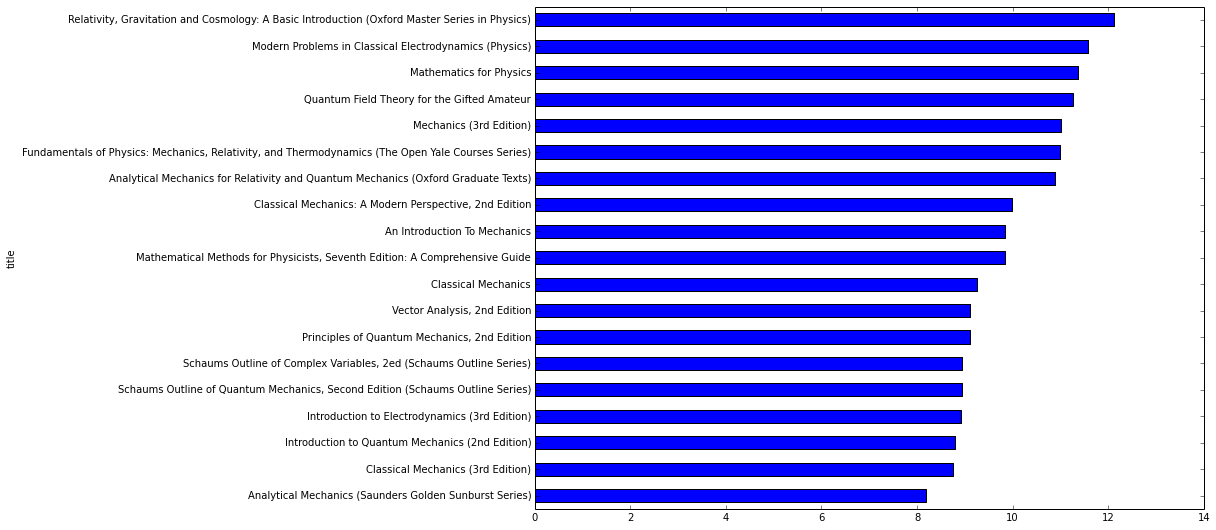

In [201]:
plot = make_plot(dfrated)

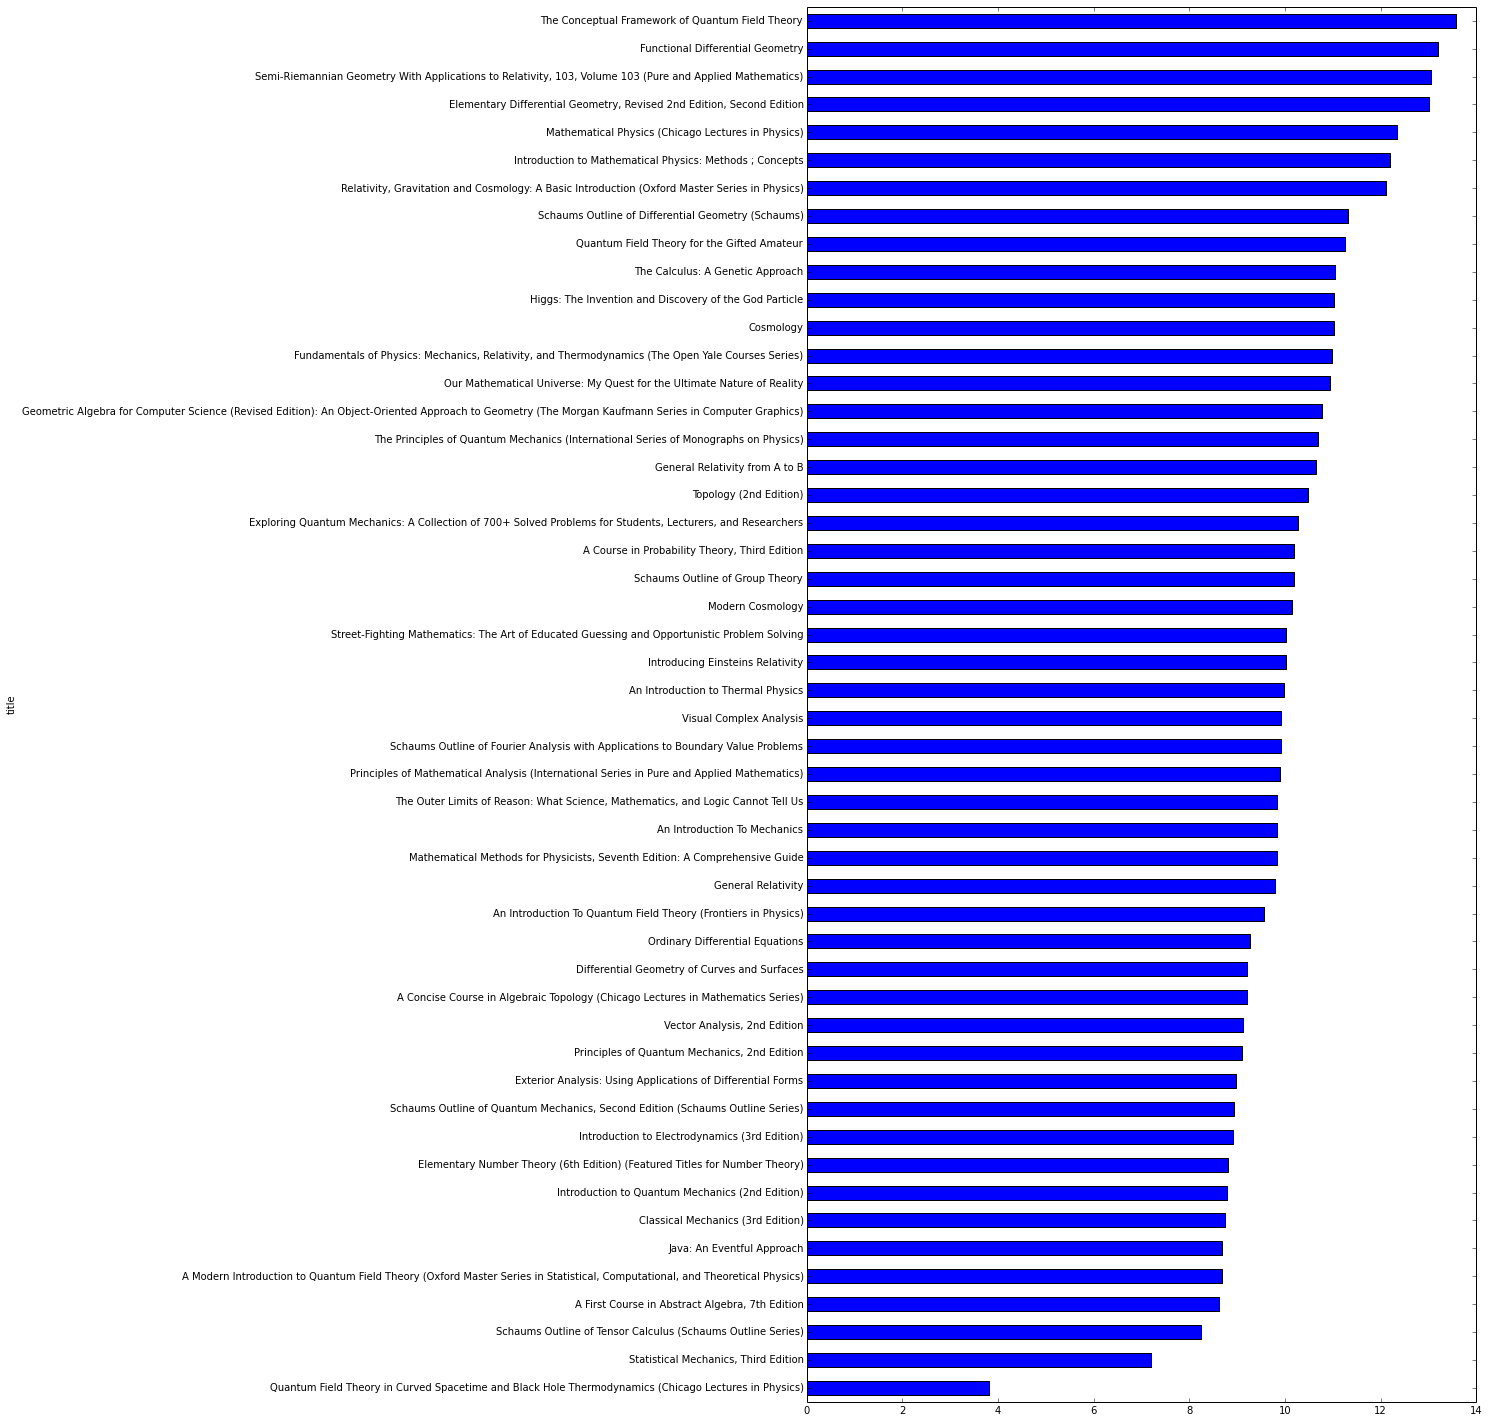

In [182]:
#### %matplotlib inline

plot = dfplot.Difficulty.plot(kind='barh', figsize=(12, len(dfplot.index)/2))


In [37]:
# ------------WISDOM FROM ALEX TOMBERG --------------------
row.asin.values[0]

import numpy as np

asin = '0521468000'
asin2 = '0007162219'
asins = [asin,asin2]

selector = np.logical_or(df_m.asin == asin, df_m.asin == asin )
selector = np.logical_or(selector, df_m.asin == asin2)
#row = df_m[df_m.asin == asin]
selector.describe()

count           10010
mean     0.0001998002
std        0.01413436
min             False
25%                 0
50%                 0
75%                 0
max              True
Name: asin, dtype: object

In [189]:
df_m[df_m.title == 'Classical Mechanics']

,asin,title,imgUrl,relevant_asins,sales_rank
1072,0131370766,Classical Mechanics,http://ecx.images-amazon.com/images/I/21zRerA5...,0070037345 0521534097 0763779601 048667164X 01...,1495131
1631,0155076302,Classical Mechanics,http://ecx.images-amazon.com/images/I/712ZX7w0...,,4380048
4316,0521534097,Classical Mechanics,http://ecx.images-amazon.com/images/I/41ru-DXt...,0521876222 019969933X 0300192207 1107617529 18...,1183526
9312,189138922X,Classical Mechanics,http://ecx.images-amazon.com/images/I/41KwihBS...,0321856562 0131118927 013805326X 0471198269 02...,29278
